**Data Science for Good: City of Los Angeles**

Job postings can affect the quality of candidates coming forward for interviews.
Job postings can encourage, or discourage, certain groups of candidates. 

In this project, we attempt to analyze the job postings put by City of LA to analyze the quality of the postings.
Doing this can allow City of LA to attract better candidates and fill open positions.

In [1]:
import os
import pandas as pd
import numpy as np
import re
from datetime import datetime
import textstat
from pylab import *
from bs4 import BeautifulSoup
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
path_to_data = '../input/CityofLA/CityofLA/'
path_to_plain_txt = '../input/cityofla/CityofLA/Job Bulletins/' #who decided to put a space in file name?!
path_to_add = '../input/CityofLA/CityofLA/Additional data/'

#check that all the files are here
list_of_files = os.listdir(path_to_plain_txt)
print('There are %s files' % len(list_of_files))

There are 683 files


Not going to waste time! Our first step for this competition is to prepare all the .txt files and arrange them into a *cough* nice csv format.

Let's parse the files, using RE. 

We started with all these RE in a utils file, but since kernels aren't really good for that, we'll just run them here. 
A good tool for extracrting patterns, without ending bald is this website:
[**https://txt2re.com/**]

In [3]:
re_opendate = re.compile(r'(Open [D,d]ate:)(\s+)(\d\d-\d\d-\d\d)')
re_opendate_alt = re.compile('((?:[0]?[1-9]|[1][012])[-:\\/.](?:(?:[0-2]?\\d{1})|(?:[3][01]{1}))[-:\\/.](?:(?:\\d{1}\\d{1})))(?![\\d])', re.IGNORECASE|re.DOTALL)
re_salary = re.compile(r'\$(\d+,\d+)((\s(to|and)\s)(\$\d+,\d+))?')    
re_requirements = re.compile(r'(REQUIREMENTS?/\s?MINIMUM QUALIFICATIONS?)(.*)(PROCESS NOTE)')    
re_requirements_alt = re.compile(r'(or\s\d. | or\d. )(\s)(.*)')
re_sub_requirements = re.compile('r(1.|2.|3.|4.|5.|6.|7.|8.|9.)\s(.*)')
re_duties = re.compile(r'(DUTIES)(.*)(REQ[A-Z])')
re_end_date = re.compile(r'(JANUARY|FEBRUARY|MARCH|APRIL|MAY|JUNE|JULY|AUGUST|SEPTEMBER|OCTOBER|NOVEMBER|DECEMBER)\s(\d{1,2},\s\d{4})')
re_job_class = re.compile(r'\s\d{4}\s')
re_school_type = re.compile(r'\s([C,c]ollege|[U,u]university)\s')
re_full = re.compile(r'(full-time)', re.IGNORECASE)
re_part = re.compile(r'(part-time)', re.IGNORECASE)
re_xp_years = re.compile(r'(two|three|four|five|six|seven|eight|nine|ten)\s(years)', re.IGNORECASE)
re_xp_year = re.compile(r'(one)\s(year)', re.IGNORECASE)

At this point, the only thing left to do is run a loop on all the files, and praying we didn't miss any exception. 

In [4]:
#we create a df that will contain the chosen features, let it empty, avoid having troubles with changing columns twice or index etc,
#since we enhance the feature extraction everytime 
features = pd.DataFrame()

#let's loop, brace yourself, win- It's getting ugly

for file_name in list_of_files:
    titles = []
    try:
        f = open(path_to_plain_txt + file_name, "r")
        file = f.read().replace('\t', '')
        text = file.replace('\n', '')
   
        titles = [title for title in file.split('\n') if title.isupper()] 
    
        #since I'm using a utils file, there's no confusion between re variables and the csv. (You can see that this is obsolete... )
        salare = re.search(re_salary, text)
        
        try:
            date = re.search(re_opendate, text).group(3)
        except Exception:
            try:
                date = re.search(re_opendate_alt, text).group()
            except Exception as e:
                print(e)
                date = "Not data"
        
        try:
            duties = re.search(re_duties, text).group(2)
        except Exception as e:
            duties = "No details"
        try:
            requirements = re.search(re_requirements, text).group(2)
        except Exception as e:
            try:#I took this part from the beautiful kernel of: 
                requirements = re.search('(.*)NOTES?',re.findall(r'(REQUIREMENTS?)(.*)(NOTES?)',
                              text)[0][1][:1200]).group(1)
            except Exception as e:
                requirements = "Parse it by hand!"
        if requirements not in "Parse it by hand!":
            try:
                sub_requirements = re.search(re_sub_requirements, text).group()
            except Exception as e:
                sub_requirements = "None"

            
        try:
            end_date = re.search(re_enddate,text).group()
        except Exception as e:
            end_date = np.nan
        
        #requirements_1 = re.search(utils.sub_requirements, requirements).group(1)
        #requirements_sub = re.search(utils.sub_requirements, requirements).group(1,2)
        
        selection = [z[0] for z in re.findall('([A-Z][a-z]+)((\s\.\s)+)', text)]
        
        try:
            job_class = re.search(re_job_class, file_name).group()
        except Exception as e:
            job_class = "unknown"
        
        try:
            school_type = re.search(re_school_type, requirements).group()
        except Exception as e:
            school_type = "Not stated"
            
        if "college" in school_type:
            school_type = "College or University"
        elif "university" in school_type:
            school_type = "College or University"
        
        try: 
            sal_low = salare.group(1).replace("$", "").replace(",", "")
        except Exception as e:
            sal_low = "To be determined"
    
        try:
            sal_up = salare.group(5).replace(",", "").replace("$","")
        except Exception as e:
            sal_up = "To be determined"
        try:
            full = re.search(re_full, requirements).group()
        except Exception as e:
            full = ""
        try:
            part = re.search(re_part, requirements).group()
        except Exception as e:
            part = ""
            
        if(full != "" and part != ""):
            full_part_time = full + "," + part
        elif(full == ""):
            full_part_time = part
        else:
            full_part_time = full
            
        #We got all the features we wanted, now clean a bit to make the reading easier
        try:
            xp_years = re.search(re_xp_years, requirements).group()
        except Exception as e:
            try:
                xp_years = re.search(re_xp_year, requirements).group()
            except Exception as e:
                xp_years = "not found"

        
        requirements = requirements.replace(sub_requirements, "")
        requirements = requirements.replace("/", "")
        requirements = requirements.replace("MINIMUM QUALIFICATION", "")
        requirements = requirements.replace("1. ", "")
        sub_requirements = sub_requirements.replace("r2", "")
        sub_requirements = sub_requirements.replace("r3", " .")
        selection = str(selection).replace('[','').replace(']','')
        selection = selection.replace("'", "")

        line = pd.DataFrame({'Job_title': titles[0],
                        'Job class': [job_class],
                        'Salary lower range': [sal_low],
                        'Salary upper range': [sal_up], 
                        'Opening date': [date],
                        'Full_time_Part_Time':[full_part_time],
                        'Years of experience':[xp_years],
                        'Requirements': [requirements],
                        'Sub requirements':[sub_requirements],
                        'School type':[school_type],
                        'Duties': [duties], 
                        'Deadline': [end_date],
                        'Selection': [selection]
        })
        features = features.append(line, ignore_index = True)
        
        
    except Exception as e:
        print(file_name)
        print(e)

#and now we write everything in the CSV
export_csv = features.to_csv ('features_extracted_beta.csv', index = None, header=True)

POLICE COMMANDER 2251 092917.txt
'utf-8' codec can't decode byte 0xe9 in position 951: invalid continuation byte
'NoneType' object has no attribute 'group'


Phew, the biggest part is done. 
And right now, we have the dataset in a nice .csv format.
A preview of the csv as below.

In [5]:
df=pd.read_csv('features_extracted_beta.csv')
df.head()

,Job_title,Job class,Salary lower range,Salary upper range,Opening date,Full_time_Part_Time,Years of experience,Requirements,Sub requirements,School type,Duties,Deadline,Selection
0,ARTS ASSOCIATE,2454,48797,71326,07-21-17,full-time,two years,A bachelor's degree from an accredited four-ye...,. An associate of arts degree from an accredit...,College or University,An Arts Associate performs a broad range of en...,NaN,Essay
1,SENIOR COMMUNICATIONS ELECTRICIAN,3638,94941,To be determined,03-03-17,full-time,Two years,Two years of full-time paid experience in a cl...,None,Not stated,A Senior Communications Electrician acts as a ...,NaN,Interview
2,SENIOR AUTOMOTIVE SUPERVISOR,3716,103126,111875,11-20-15,full-time,Two years,Two years of full-time paid experience with th...,None,Not stated,A Senior Automotive Supervisor assists in plan...,NaN,"Essay, Interview"
3,WASTEWATER COLLECTION WORKER,4110,43973,62556,10-26-12,full-time,One year,One year of full-time paid experience with the...,. One year of full-time paid experience in the...,Not stated,A Wastewater Collection Worker performs a vari...,NaN,Test
4,SENIOR STOREKEEPER,1837,52806,77172,05-25-18,full-time,Two years,Two years of full-time paid experience as a St...,None,Not stated,"A Senior Storekeeper assigns, reviews and eval...",NaN,"Test, Interview"



For this project, we will be exploring two types of biases! 

**1) Education bias:
**
For the first type of bias, we will be looking at education bias. We determine that job postings will gear towards people who have attained a certain level of education. 

First and foremost, we have to perform data-cleaning to rid the stopwords, punctuations, and capital letters. 

In [6]:
stops_words=["i", "me", "my", "myself", "we", "our", "ours", "ourselves", "you", "your", "yours", "yourself", "yourselves", 
             "he", "him", "his", "himself", "she", "her", "hers", "herself", "it", "its", "itself", "they", "them", "their", 
             "theirs", "themselves", "what", "which", "who", "whom", "this", "that", "these", "those", "am", "is", "are",
             "was", "were", "be", "been", "being", "have", "has", "had", "having", "do", "does", "did", "doing", "a", "an", 
             "the", "and", "but", "if", "or", "because", "as", "until", "while", "of", "at", "by", "for", "with", "about", 
             "against", "between", "into", "through", "during", "before", "after", "above", "below", "to", "from", "up", 
             "down", "in", "out", "on", "off", "over", "under", "again", "further", "then", "once", "here", "there", "when", 
             "where", "why", "how", "all", "any", "both", "each", "few", "more", "most", "other", "some", "such", "no", "nor", 
             "not", "only", "own", "same", "so", "than", "too", "very", "s", "t", "can", "will", "just", "don", "should", "now", "may"]

def clean_txt(raw_txt, stops=stops_words):
    # Function to clean raw text
    # 1. Remove HTML
    raw_txt = BeautifulSoup(raw_txt, "lxml").get_text() 
    #
    # 2. Remove non-letters        
    letters_only = re.sub("[^a-zA-Z]", " ", raw_txt) 
    #
    # 3. Convert to lower case, split into individual words
    words = letters_only.lower().split()                             
    stops = set(stops)                  
    # 
    # 5. Remove stop words
    meaningful_words = [w for w in words if not w in stops]   
    #
    # 6. Join the words back into one string separated by space, 
    # and return the result.
    return( " ".join( meaningful_words )) 

df['full_description']=df['Requirements']+" "+df['Sub requirements']+" "+df['Duties']
df['Cleaned_duties']=df['Duties'].apply(clean_txt)
df['cleaned_text']=df['full_description'].apply(clean_txt)
df.head()

,Job_title,Job class,Salary lower range,Salary upper range,Opening date,Full_time_Part_Time,Years of experience,Requirements,Sub requirements,School type,Duties,Deadline,Selection,full_description,Cleaned_duties,cleaned_text
0,ARTS ASSOCIATE,2454,48797,71326,07-21-17,full-time,two years,A bachelor's degree from an accredited four-ye...,. An associate of arts degree from an accredit...,College or University,An Arts Associate performs a broad range of en...,NaN,Essay,A bachelor's degree from an accredited four-ye...,arts associate performs broad range entry leve...,bachelor degree accredited four year college u...
1,SENIOR COMMUNICATIONS ELECTRICIAN,3638,94941,To be determined,03-03-17,full-time,Two years,Two years of full-time paid experience in a cl...,None,Not stated,A Senior Communications Electrician acts as a ...,NaN,Interview,Two years of full-time paid experience in a cl...,senior communications electrician acts lead wo...,two years full time paid experience class leas...
2,SENIOR AUTOMOTIVE SUPERVISOR,3716,103126,111875,11-20-15,full-time,Two years,Two years of full-time paid experience with th...,None,Not stated,A Senior Automotive Supervisor assists in plan...,NaN,"Essay, Interview",Two years of full-time paid experience with th...,senior automotive supervisor assists planning ...,two years full time paid experience city los a...
3,WASTEWATER COLLECTION WORKER,4110,43973,62556,10-26-12,full-time,One year,One year of full-time paid experience with the...,. One year of full-time paid experience in the...,Not stated,A Wastewater Collection Worker performs a vari...,NaN,Test,One year of full-time paid experience with the...,wastewater collection worker performs variety ...,one year full time paid experience city los an...
4,SENIOR STOREKEEPER,1837,52806,77172,05-25-18,full-time,Two years,Two years of full-time paid experience as a St...,None,Not stated,"A Senior Storekeeper assigns, reviews and eval...",NaN,"Test, Interview",Two years of full-time paid experience as a St...,senior storekeeper assigns reviews evaluates w...,two years full time paid experience storekeepe...


In [7]:
#below was done as we realized that some of the job postings had no job descriptions!
df=df[df['Cleaned_duties']!='details']

Text(0.5, 1.0, 'Education level required')

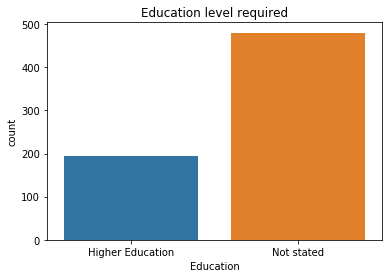

In [8]:
def change_names(x):
    if x=='College or University':
        return 'Higher Education'
    elif x=='College':
        return 'High Education'
    else:
        return 'Not stated'
df['Education']=df['School type'].apply(change_names)

sns.countplot(x='Education', data=df)
plt.title("Education level required")

With the graph, we can see that there are more jobs in LA that does not require one to have a degree.

Text(0.5, 1.0, 'Wordcloud analysis of Job Description')

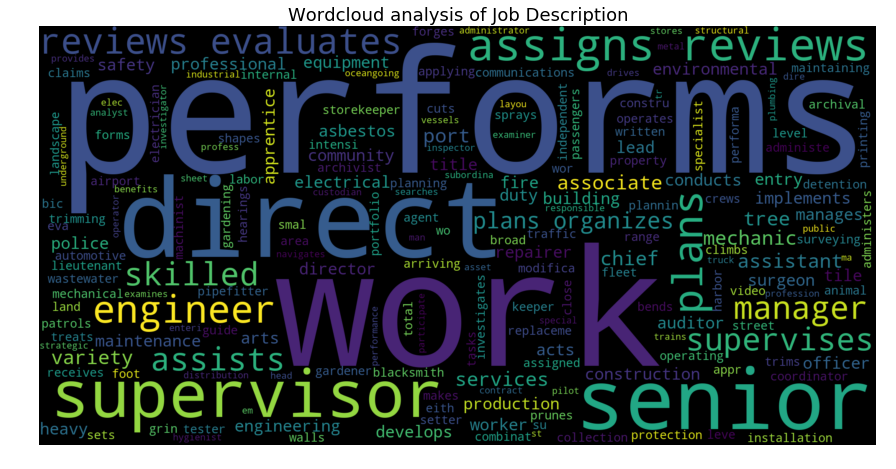

In [9]:
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator

wordcloud = WordCloud(width=2000, height=1000).generate(str(df['Cleaned_duties']))
fig=plt.figure(figsize=(15,12))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.title("Wordcloud analysis of Job Description", fontsize=18)

Visualizing the wordcloud, we explore the more salient words in our dataset.
Thereafter, we decided to visualize the words in postings for people with degrees, and postings for people who are not required to have a degree.

Text(0.5, 1.0, 'Wordcloud analysis of Job Description for Education-Not Stated')

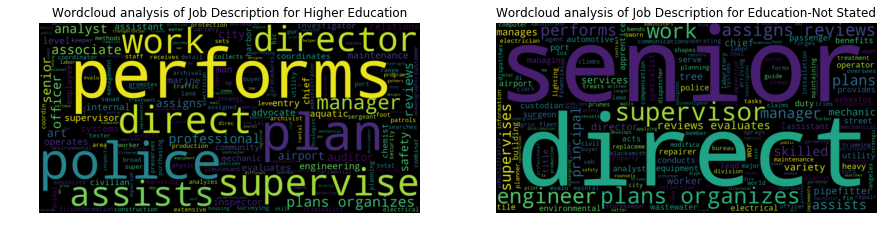

In [10]:
fig=plt.figure(figsize=(15,12))

plt.subplot(1,2,1)
df_he=df[df['Education']=='Higher Education']
wordcloud2 = WordCloud(width=2000, height=1000).generate(str(df_he['Cleaned_duties']))
plt.imshow(wordcloud2, interpolation='bilinear')
plt.axis("off")
plt.title("Wordcloud analysis of Job Description for Higher Education", fontsize=12)

plt.subplot(1,2,2)
df_no_he=df[df['Education']=='Not stated']
wordcloud3 = WordCloud(width=2000, height=1000).generate(str(df_no_he['Cleaned_duties']))
plt.imshow(wordcloud3, interpolation='bilinear')
plt.axis("off")
plt.title("Wordcloud analysis of Job Description for Education-Not Stated", fontsize=12)

We can see how they differ (in a general way)

Words like "perform", "manage", "assist" are more present in a high education posintg. While "senior", "mechanic" and "service" are representative of a technical job, this clearly show the bias. 
Obviously, the word used in the job postings related to less educational requiring fields will tend [to scare off ](http://)younger generations. 

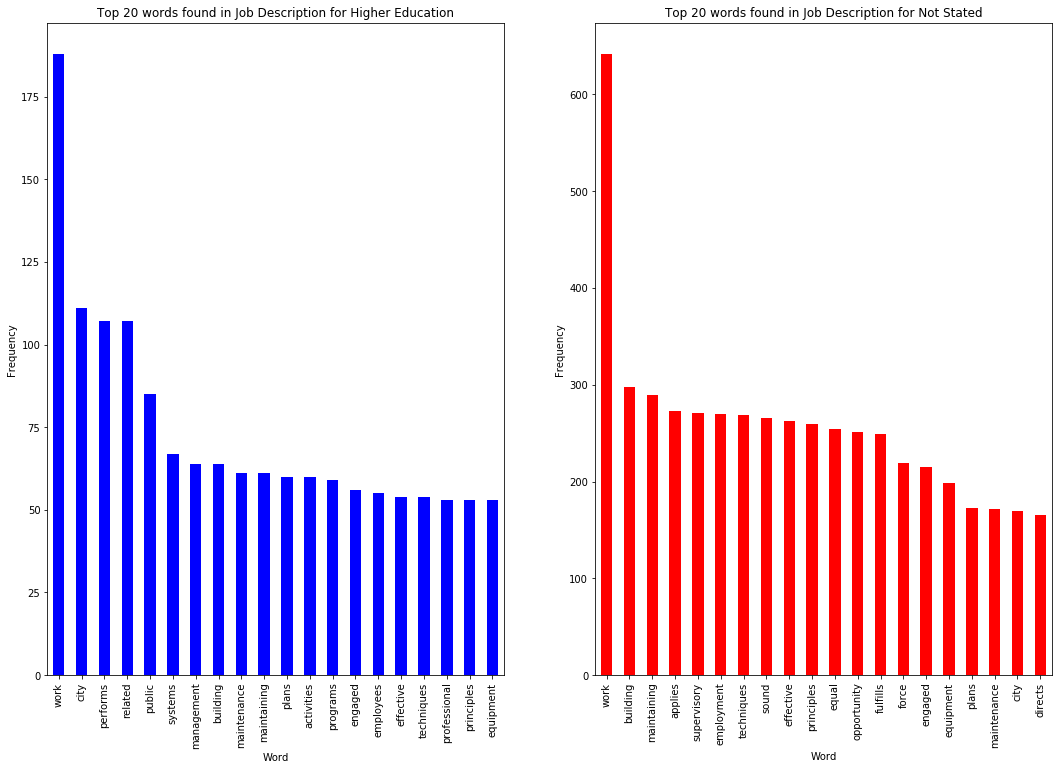

In [11]:
# TOP WORDS FOR HIGHER EDUCATION
duties_into_arr_he=df_he['Cleaned_duties'].values
all_words_duties_he=''.join(duties_into_arr_he).split()
df_word_count_he=pd.DataFrame([[x,all_words_duties_he.count(x)] for x in set(all_words_duties_he)]).rename(columns={0:'word', 1:'word_count'})
word_count_top_he=df_word_count_he.sort_values(by='word_count', ascending=False).head(20).set_index('word')

# TOP WORDS FOR NOT STATED
duties_into_arr_nohe=df_no_he['Cleaned_duties'].values
all_words_duties_nohe=''.join(duties_into_arr_nohe).split()
df_word_count_nohe=pd.DataFrame([[x,all_words_duties_nohe.count(x)] for x in set(all_words_duties_nohe)]).rename(columns={0:'word', 1:'word_count'})
word_count_top_nohe=df_word_count_nohe.sort_values(by='word_count', ascending=False).head(20).set_index('word')

fig = plt.figure(figsize=(18,12))

plt.subplot(1,2,1)
ax=word_count_top_he['word_count'].plot(kind='bar', color='blue')

plt.xlabel('Word')
plt.ylabel('Frequency')
plt.title('Top 20 words found in Job Description for Higher Education')
plt.grid(False)

plt.subplot(1,2,2)
ax=word_count_top_nohe['word_count'].plot(kind='bar', color='red')

plt.xlabel('Word')
plt.ylabel('Frequency')
plt.title('Top 20 words found in Job Description for Not Stated')
plt.grid(False)

**FOOD FOR THOUGHT**

It seems that for job postings that were meant for candidates without a degree, the City of LA was assuring that they are an "Equal Opportunity Employer" (as seen on the graph on the right).
If there are no biases against people with no higher education background, is it absolutely necessary to state that you are an "Equal Opportunity Employer?" when it is not present in the high education postings.

Does the term "Equal Opportunity Employer" serve as a self-serving term that this role is marketed towards people with no higher education background?

We also need to keep in mind that these kind of words tend to push away minorities in terms of ethnicity, religion and disability etc... 

**READABILITY**

The Flesch Reading Ease test (Kincaid, Fishburne, Rogers, & Chissom, 1975) is a common measurement tool developed with the purpose of measuring the readability the text. Higher scores indicate that the text is easier to read, while lower scores indicate that the text is harder to read.
The Dale-Chall (1995) readability test works a bit the same way, with values higher than 9.0 mean that the reader would need a degree to understand the text. 
The textstat package allows us to implement both algorithms in Python. 


*The readability algorithms are based on length or senteces, hard words etc... The interpretation need to take this into account!

Full reference to the paper: 





1.   Chall, J.S., & Dale, E. (1995). Readability revisited. ISBN 1571290087.
2.   Kincaid, J.P., Fishburne, R.P., Rogers, R.L., & Chissom, B.S. (1975). Derivation of new readability formulas (automated readability index, fog count, and flesch reading ease formula) for Navy enlisted personnel. Research Branch Report 8–75. Chief of Naval Technical Training: Naval Air Station Memphis


Full reference to Wikipedia page for easy reading:





1.   https://en.wikipedia.org/wiki/Dale%E2%80%93Chall_readability_formula
2.   https://en.wikipedia.org/wiki/Flesch%E2%80%93Kincaid_readability_tests#cite_note-kincaidetal1975-1



There are 675 jobs


(array([ 0.,  0.,  0.,  2.,  1.,  3., 14., 28., 41., 90.]),
 array([ 5.,  6.,  7.,  8.,  9., 10., 11., 12., 13., 14., 15.]),
 <a list of 10 Patch objects>)

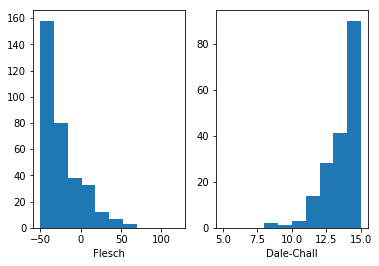

In [12]:
#we read the csv created above
#df = pd.read_csv("features_extracted_beta.csv")
requirements = df["Cleaned_duties"]
job_titles = df["Job_title"]

#kind of logging to check I have no error on the df size
print("There are %s jobs" %len(df))

#And compute the readability with two different techniques on the requirements
flesch_ease_of_read = [textstat.flesch_reading_ease(req) for req in requirements]
dale_chall_ease_of_read = [textstat.dale_chall_readability_score(req) for req in requirements] 
    
#some statistical tools   
flesch_mean = np.mean(flesch_ease_of_read)
flesch_std = np.std(flesch_ease_of_read)
flesch_ease_of_read = [flesch_ease_of_read, job_titles.tolist()]

dale_chall_mean = np.mean(dale_chall_ease_of_read)
dale_chall_std = np.std(dale_chall_ease_of_read)
dale_chall_ease_of_read = [dale_chall_ease_of_read, job_titles.tolist()] 

#plots 
subplot(1,2,1)
plt.xlabel("Flesch")
hist(flesch_ease_of_read[0], range = (-50, 121))

subplot(1,2,2)
plt.xlabel("Dale-Chall")
hist(dale_chall_ease_of_read[0], range = (5,15))



(array([248.,  74.,   1.,  28.,  61.,  49.,  12.,   5.,   1.,   1.]),
 array([ 8.21 , 16.676, 25.142, 33.608, 42.074, 50.54 , 59.006, 67.472,
        75.938, 84.404, 92.87 ]),
 <a list of 10 Patch objects>)

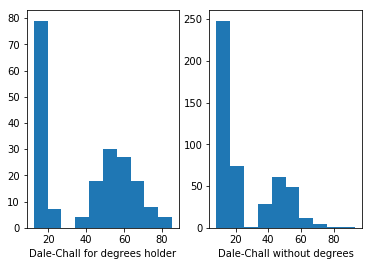

In [13]:
#We split the df between the jobs that require a degree and those that dont (but they may require a certification?)
grad = df[df['Education']=='Higher Education']['cleaned_text']
no_qualif = df[df['Education']!='Higher Education']['cleaned_text']

#As above, we compute the readability for these two categories 
dc_grad_ease_of_read = [textstat.dale_chall_readability_score(val) for val in grad]    
dc_no_Qualif_ease_of_read = [textstat.dale_chall_readability_score(val) for val in no_qualif]

#Finally, some plot to help visualize
subplot(1,2,1)
xlabel("Dale-Chall for degrees holder")
hist(dc_grad_ease_of_read)

subplot(1,2,2)
xlabel("Dale-Chall without degrees")
hist(dc_no_Qualif_ease_of_read)

The job postings are generally very hard to read! 
We can see that some of the jobs that don't require a degree have more understandable job postings (values <9.0), but it is definitely not enough when we compare the frequencies. 

In [14]:
my_dict = {'method ':['mean','median'],
           'Higher Education':[np.mean(dc_grad_ease_of_read),np.median(dc_grad_ease_of_read)],
           'Not Required':[np.mean(dc_no_Qualif_ease_of_read),np.median(dc_no_Qualif_ease_of_read)]}
pd.DataFrame(my_dict)

,method,Higher Education,Not Required
0,mean,39.507128,26.714479
1,median,44.380000,16.335000


**2) Gender bias:
**
For the second type of bias, we will be looking at education bias. We determine that job postings will gear towards people of a particlar gender.

The analysis of this section is inspired by the work done by Gaucher, Friesen, and Kay (2011) and the webpage and Github repository by Kat Matfield (http://gender-decoder.katmatfield.com/).

Full reference to paper:

1.   Gaucher, D., Friesen, J., & Kay, A. C. (2011). Evidence That Gendered Wording in Job Advertisements Exists and Sustains Gender Inequality. Journal of Personality and Social Psychology, 101(1), 109-28. doi: 10.1037/a0022530


In [15]:
def gender_check(text, vocabulary):
    bias_word = [word for word in text.split(" ") for gender_word in vocabulary if word.startswith(gender_word)]
    return (bias_word)

#list of word obtained obtained from the above paper by Gaucher et al. (2011)
masculine_words=['active','adventurous','aggress','ambitio','analy','assert','athlet','autonom','boast','challeng',
                 'compet','confident','courag','decide','decisive','decision','determin','dominant','domina',
                 'force','greedy','headstrong','hierarch','hostil','implusive','independen',
                 'individual','intellect','lead','logic','masculine','objective','opinion','outspoken','persist','principle',
                 'reckless','stubborn','superior','confiden','sufficien','relian']
feminine_words=['affectionate','child','cheer','commit','communal','compassion','connect','considerate',
                'cooperat','depend','emotion','empath','feminine','flatterable','gentle','honest','interpersonal',
                'interdependen','interpersona','kind','kinship','loyal','modesty','nag','nurtur','pleasant','polite',
                'quiet','respon','sensitiv', 'submissive','support','sympath','tender','together','trust',
                'understand','warm','whin','yield']

df['men_words']=df.apply(lambda x: gender_check(x['cleaned_text'], masculine_words), axis=1)
df['women_words']=df.apply(lambda x: gender_check(x['cleaned_text'], feminine_words), axis=1)

def element_counter(text):
    return len(text)

df['no_of_men_words']=df['men_words'].apply(element_counter)
df['no_of_women_words']=df['women_words'].apply(element_counter)

Text(0.5, 1.0, 'No gender bias towards men (False) vs. Gender bias towards men (True)')

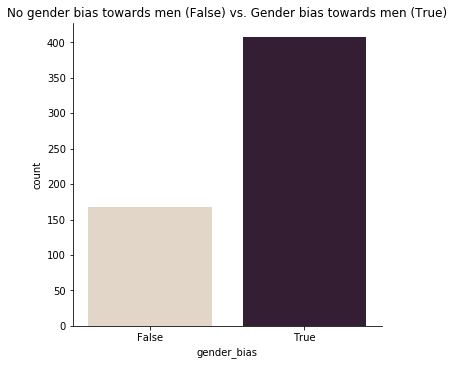

In [16]:
df['Salary_lower_range']=df['Salary lower range'].str.extract('(\d+)')
df['Salary_upper_range']=df['Salary upper range'].str.extract('(\d+)')

salary_df=df[['no_of_men_words','no_of_women_words','Salary_lower_range','Salary_upper_range']]
salary_df=salary_df.dropna(axis=0).astype('int')

salary_df['men_women_words']=df['no_of_men_words']-df['no_of_women_words']
salary_df['gender_bias']=salary_df['men_women_words'].apply(lambda x: True if x>0 else False)

sns.catplot(x="gender_bias", kind="count", palette="ch:.25", data=salary_df)
plt.title("No gender bias towards men (False) vs. Gender bias towards men (True)")

Graph above indicates that there are more jobs that contain words that are biased towards the male gender.

Text(0.5, 1.0, 'Top jobs with most no. of masculine words')

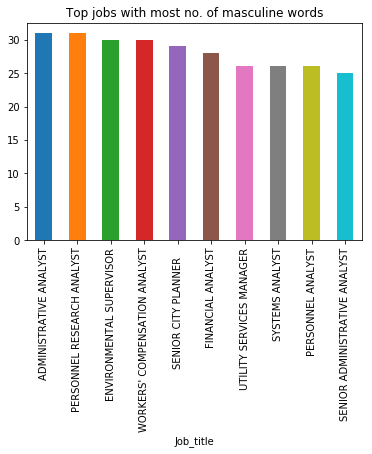

In [17]:
df.groupby('Job_title')['no_of_men_words'].sum().sort_values(ascending=False).head(10).plot(kind='bar')
plt.title('Top jobs with most no. of masculine words')

Text(0.5, 1.0, 'Top jobs with most no. of feminine words')

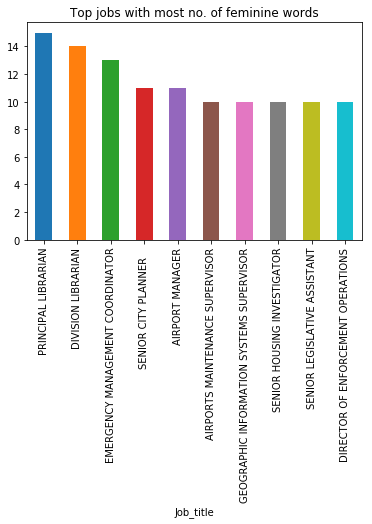

In [18]:
df.groupby('Job_title')['no_of_women_words'].sum().sort_values(ascending=False).head(10).plot(kind='bar')
plt.title('Top jobs with most no. of feminine words')

In [19]:
#Let's find out the full written job description for the position of Personnel Research Analyst
pd.options.display.max_colwidth = 1000
df[df['Job_title']=='PERSONNEL RESEARCH ANALYST']['Duties']

293    A Personnel Research Analyst performs specific technical research in a broad range of personnel selection activities; carries out content and criterion validation studies; conducts detailed job analyses; develops and administers selection tests; performs complete statistical and data analyses; writes a variety of statistical and narrative reports; and applies professional selection testing practices and the principles of equal employment opportunity to personnel selection and research.
Name: Duties, dtype: object

Looking at the above text, are analyst positions too catered towards males?
It would be interesting to find out whether there is an over-representation of males in the analyst positions under the City of LA.

In [20]:
#Let's find out the full written job description for the position of Principal Librarian
df[df['Job_title']=='PRINCIPAL LIBRARIAN']['Duties']

514    A Principal Librarian plans, organizes, directs, and supervises the work of library personnel at regional and neighborhood branch libraries, a Central Library department, or system-wide level, including Engagement and Learning, Emerging Technologies and Collections, or in a specialized library administrative function; ensures strategic goals and objectives are accomplished; represents and advocates for the library at community events and among diverse constituencies; may represent the Library Department and speak before elected officials, potential donors, and other public and private organizations; may interact with community based organizations and support groups, other city departments, vendors and contractors; plans, implements and reviews budgetary expenditures; applies sound supervisory principles and techniques in building and maintaining an effective work force; and fulfills equal employment opportunity responsibilities.
Name: Duties, dtype: object

And is the job description above geared towards women more?

Text(0.5, 1.0, 'Salary Upper Range')

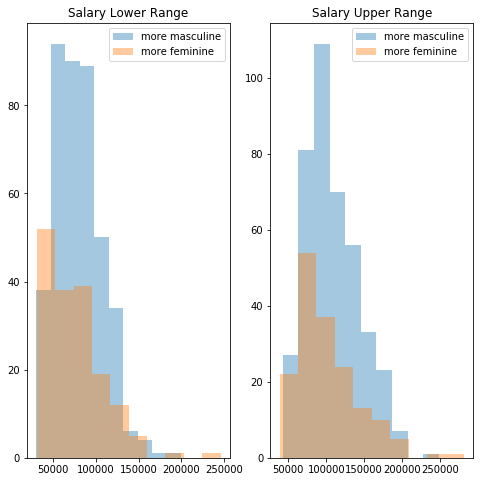

In [21]:

fig=plt.figure(figsize=(8,8))

plt.subplot(1,2,1)
plt.hist(salary_df[salary_df['gender_bias']==True]['Salary_lower_range'], label='more masculine', 
         alpha=0.4)
plt.hist(salary_df[salary_df['gender_bias']==False]['Salary_lower_range'], label='more feminine', 
         alpha=0.4)
plt.legend(loc='upper right')
plt.title('Salary Lower Range')

plt.subplot(1,2,2)
plt.hist(salary_df[salary_df['gender_bias']==True]['Salary_upper_range'], label='more masculine', 
         alpha=0.4)
plt.hist(salary_df[salary_df['gender_bias']==False]['Salary_upper_range'], label='more feminine', 
         alpha=0.4)
plt.legend(loc='upper right')
plt.title('Salary Upper Range')



Looking at the mean and mode of the salary from both lower and upper ranges, jobs that contain more masculine words saw higher mean and mode than jobs with more feminine words.

Text(0.5, 1.0, 'top 10 feminine words in job description')

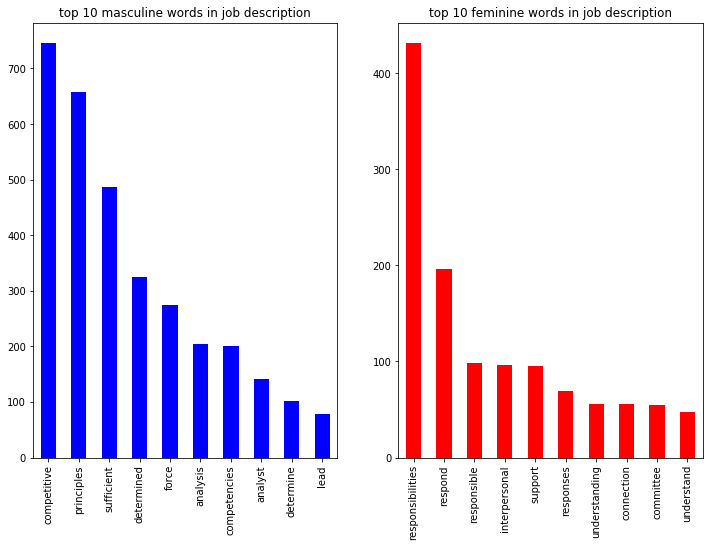

In [22]:
list_of_men_words=list(df['men_words'].dropna().str.join(" "))
list_of_men_words=' '.join(list_of_men_words).split(' ')

list_of_men_words=[word for word in list_of_men_words if word != '']

men_words_table=pd.DataFrame(list_of_men_words).rename(columns={0:'word'})

list_of_women_words=list(df['women_words'].dropna().str.join(" "))
list_of_women_words=' '.join(list_of_women_words).split(' ')

list_of_women_words=[word for word in list_of_women_words if word != '']

women_words_table=pd.DataFrame(list_of_women_words).rename(columns={0:'word'})

fig=plt.figure(figsize=(12,8))

subplot(1,2,1)
men_words_table['word'].value_counts().head(10).plot(kind='bar', color='blue')
plt.title('top 10 masculine words in job description')

subplot(1,2,2)
women_words_table['word'].value_counts().head(10).plot(kind='bar', color='red')
plt.title('top 10 feminine words in job description')

Lastly, masculine words such as 'competitive', 'principles', 'sufficient' appear very often in job descriptions, whereas feminine 
words such as 'responsibilities', 'respond' appear more.


Though the above words should be minimized in order to ensure that an equal representation of both genders during job application, the words above by Gaucher et al. (2011) are not exhaustive. The above words provided should ideally be updated due to the advent of new occupations in the job market today (especially with more and more data science positions, and the word "analyze" is often used to describe data science and data analytic positions). However, the City of LA could attempt to minimize having too many of the above masculine and feminine words if they wish to attract a pool of candidates that are more representative of the gender proporiton. 